## Linear Regression using a Neural Network with Pytorch

In [1]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import torch

Load data from file

In [2]:
data=np.load('data_linear_regression.npy', allow_pickle=True)
data=data.item()
data.keys()

dict_keys(['X_train', 'Y_train', 'X_val', 'Y_val', 'X_test', 'Y_test'])

In [3]:
type(data)

dict

In [4]:
X_train=data['X_train']
Y_train=data['Y_train']
X_val=data['X_val']
Y_val=data['Y_val']
X_test=data['X_test']
Y_test=data['Y_test']

In [5]:
X_train.shape

(800, 2)

Text(0.5, 0, 'Y')

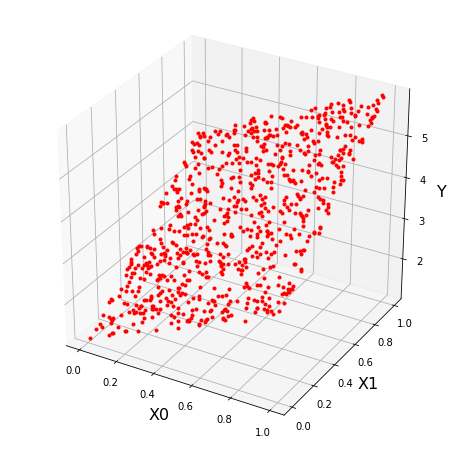

In [6]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot(X_train[:,0], X_train[:,1], Y_train.squeeze(), 'r.')
ax.set_xlabel('X0', fontsize=16)
ax.set_ylabel('X1', fontsize=16)
ax.set_zlabel('Y', fontsize=16)

define a dataset to hold/represent the data <br>
`MyDataset` is a Python class, derived from `torch_dataset`

In [7]:
from torch.utils.data import Dataset as torch_dataset
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        # return a data point (x,y) by idx (index)
        # we need to convert numpy array to torch tensor
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [8]:
dataset_train = MyDataset(X_train, Y_train)
dataset_val = MyDataset(X_val, Y_val)
dataset_test = MyDataset(X_test, Y_test)

In [9]:
dataset_train[0] # get the first data point in the training set

(tensor([0.5488, 0.7152]), tensor([4.2725]))

In [10]:
len(dataset_train) # get the number of data points in the training set

800

In [11]:
X_train.shape

(800, 2)

create dataloaders which will be used to generate minibatches <br>
batch_size=64 means each minibatch contains 64 data points  <br>
note: the last minibatch may contain less than 64 data points

In [12]:
from torch.utils.data import DataLoader as torch_dataloader
dataloader_train = torch_dataloader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
dataloader_val = torch_dataloader(dataset_val, batch_size=64, shuffle=False, num_workers=0) 
dataloader_test = torch_dataloader(dataset_test, batch_size=64, shuffle=False, num_workers=0) 

In [13]:
dataloader_train.dataset[0] # get the first data point in the traning set

(tensor([0.5488, 0.7152]), tensor([4.2725]))

In [14]:
len(dataloader_train) # get the number of minibatches

13

We can use a dataloader to generate minibatches 

In [15]:
for epoch in range(0, 1): # change 1 to 100 if we need to train the model for 100 epochs
    for batch_idx, (X, Y) in enumerate(dataloader_train):
        print(batch_idx, X.shape, Y.shape)

0 torch.Size([64, 2]) torch.Size([64, 1])
1 torch.Size([64, 2]) torch.Size([64, 1])
2 torch.Size([64, 2]) torch.Size([64, 1])
3 torch.Size([64, 2]) torch.Size([64, 1])
4 torch.Size([64, 2]) torch.Size([64, 1])
5 torch.Size([64, 2]) torch.Size([64, 1])
6 torch.Size([64, 2]) torch.Size([64, 1])
7 torch.Size([64, 2]) torch.Size([64, 1])
8 torch.Size([64, 2]) torch.Size([64, 1])
9 torch.Size([64, 2]) torch.Size([64, 1])
10 torch.Size([64, 2]) torch.Size([64, 1])
11 torch.Size([64, 2]) torch.Size([64, 1])
12 torch.Size([32, 2]) torch.Size([32, 1])


We can see that each of the first 12 minibatches contains 64 data points <br>
The last minibatch contains less than 64 data points

Now, let's build a neural network that has only a linear layer - because we are doing linear regression

In [16]:
import torch.nn as nn
class Net(nn.Module): # nn.Module is the parent class
    def __init__(self, input_dim, output_dim):
        super().__init__() #always call super here
        self.layer1 = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        y=self.layer1(x)
        return y

create an instance object of the class

In [17]:
model=Net(input_dim=2, output_dim=1)

In [18]:
#move the model to GPU if you have a GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer1): Linear(in_features=2, out_features=1, bias=True)
)

In [19]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.5767, -0.4984]], requires_grad=True), Parameter containing:
 tensor([-0.6568], requires_grad=True)]

create an optimizer that does stochastic gradient descent <br>
send the parameters of the linear_model to the optimizer

In [20]:
import torch.optim as optim

In [21]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
#optimizer=optim.Adam(model.parameters(), lr=0.01)

define a function to train the neural network in one epoch

In [22]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter, dL/dW=0
        Yp = model(X)#forward pass
        loss = torch.mean((Yp-Y)**2) # MSE loss or other loss
        loss.backward()#backward pass to get dL/dW
        optimizer.step()#update parameters:  W <= w - lr *dL/dW
        loss_train+=loss.item()#always use .item()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    return loss_train

define a function to evaluate the neural network on the validation set or the testing set

In [23]:
def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    mae_test=0
    sample_count=0
    with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Yp = model(X)#forward pass
            loss_test+=torch.sum((Yp-Y)**2).item()
            mae_test+= torch.sum((Yp-Y).abs()).item()
            sample_count+=X.size(0)
    loss_test/=sample_count
    mae_test/=sample_count
    return loss_test, mae_test

train the neural network model for many epochs

In [24]:
loss_train_list=[]
loss_val_list=[]

In [25]:
for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train=train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    #-------- perform validation --------------------------------
    loss_val, mae_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

Train Epoch: 0 [0/800 (0%)]	Loss: 19.799601
Train Epoch: 0 [64/800 (8%)]	Loss: 17.138905
Train Epoch: 0 [128/800 (15%)]	Loss: 15.679514
Train Epoch: 0 [192/800 (23%)]	Loss: 12.886635
Train Epoch: 0 [256/800 (31%)]	Loss: 9.500296
Train Epoch: 0 [320/800 (38%)]	Loss: 8.154890
Train Epoch: 0 [384/800 (46%)]	Loss: 5.699118
Train Epoch: 0 [448/800 (54%)]	Loss: 2.675232
Train Epoch: 0 [512/800 (62%)]	Loss: 1.340051
Train Epoch: 0 [576/800 (69%)]	Loss: 0.648323
Train Epoch: 0 [640/800 (77%)]	Loss: 0.326388
Train Epoch: 0 [704/800 (85%)]	Loss: 0.399012
Train Epoch: 0 [384/800 (92%)]	Loss: 0.619955
epoch 0 training loss: 7.297532145793621
epoch 0 validation loss: 1.3051657032966615
Train Epoch: 1 [0/800 (0%)]	Loss: 1.439169
Train Epoch: 1 [64/800 (8%)]	Loss: 1.897530
Train Epoch: 1 [128/800 (15%)]	Loss: 2.303929
Train Epoch: 1 [192/800 (23%)]	Loss: 2.838088
Train Epoch: 1 [256/800 (31%)]	Loss: 3.117795
Train Epoch: 1 [320/800 (38%)]	Loss: 2.956637
Train Epoch: 1 [384/800 (46%)]	Loss: 2.850972
T

draw the curves of loss vs epoch

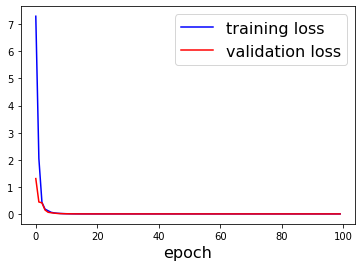

In [26]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax.plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax.set_xlabel('epoch',fontsize=16)
ax.legend(fontsize=16)

Usually, we need to tune the hyperparameters of a neural network, <br>
such as the number of layers, the number of units in each layer <br>
For this simple example, we can skip this step

after training, we evaluate the model on the testing dataset

In [27]:
mse_test, mae_test = test(model, dataloader_test, device)
print('test mse:', mse_test)
print('test mae', mae_test)

test mse: 0.0008442801758646965
test mae 0.02519878673553467


Let's check the parameters of the model

In [28]:
list(model.parameters())

[Parameter containing:
 tensor([[2.0013, 2.9947]], requires_grad=True), Parameter containing:
 tensor([1.0510], requires_grad=True)]

Get the predicted target values on the testing set

In [29]:
X_test_t=torch.tensor(X_test, dtype=torch.float32) #convert numpy array to torch tensor
#the input to model should be torch tensor
Yp_test_t=model(X_test_t.to(device))
type(Yp_test_t)

torch.Tensor

In [30]:
Yp_test=Yp_test_t.detach().cpu().numpy() #convert torch tensor to numpy array
type(Yp_test)

numpy.ndarray

plot Yp_test vs Y_test

In [31]:
Y_test.shape

(1000, 1)

In [32]:
Yp_test.shape

(1000, 1)

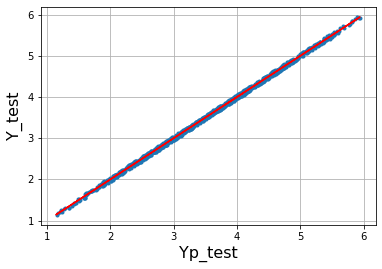

In [33]:
fig, ax = plt.subplots()
ax.plot(Yp_test, Y_test, '.')
ax.plot(Y_test, Y_test, 'r-')
ax.set_xlabel('Yp_test', fontsize=16)
ax.set_ylabel('Y_test', fontsize=16)
ax.grid(True)